In [8]:
import gc
import random
from pathlib import Path

import h5py
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Input, Conv2D, \
    Dense, concatenate, Dropout, concatenate, Dropout, BatchNormalization, AvgPool2D

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import plots

# Exploratory data analysis

The dataset consists of 8732 sound excerpts in .wav format of urban acoustics environments. Each sound excerpt is labelled with one of 10 classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gunshot, jackhammer, siren or street music. The data is organised in ten folders. Each folder contains approximately one-tenth of the total data and represents a single fold. The folds will be used in a 10-fold cross-validation. The authors emphasise that the performance on the dataset should not be evaluated through a standard train-/test split as many slices originate from the same recording. 

The class labels can either be extracted from the file names themselves or from the accompanying metadata file, which contains (among other things) information about the file name, the respective fold and the class label. 

In [3]:
metadata = pd.read_csv("/home/msc1/Desktop/CW/7146_data/UrbanSound8K.csv")

In [4]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The class distribution among the observations is shown below. The majority of classes have a similar number of observations with around 11\% share. However, three of the ten classes have fewer observations than the other classes. While the class \`siren' is only moderately below the relative distribution of the other classes, the classes \`car horn' and \`gun shot' are significantly underrepresented with a share of ~5\% and ~4\% respectively. The authors do not specify a particular reason for the imbalance as all sound excerpts were taken from the same [database](http://www.freesound.org). While the low number of gunshot excerpts may be explained by the fact that they are less prevalent in urban areas, the low number of car horns excerpts cannot be explained in the same manner, as they are quite common in urban environments. 

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Relative Distribution - Class Labels'}, xlabel='Sounds', ylabel='Distribution (relative)'>)

<Figure size 432x288 with 0 Axes>

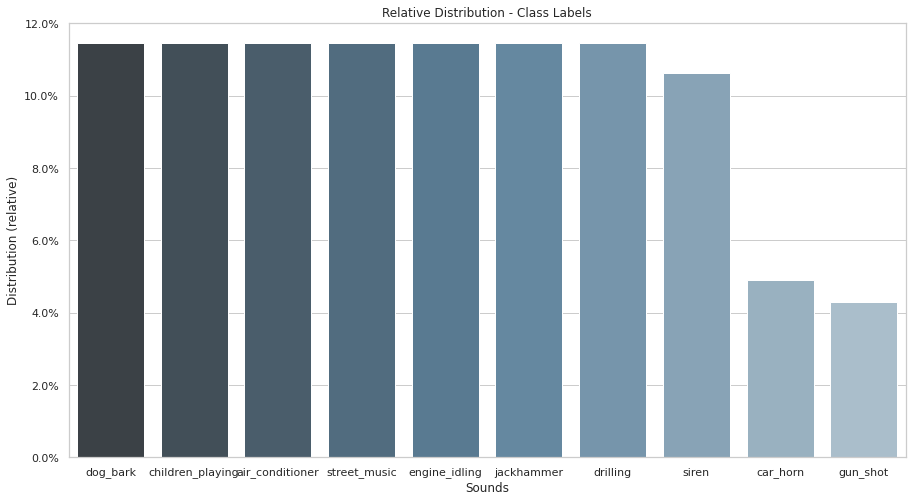

In [5]:
plots.class_imbalance(metadata)

The figure below shows the class distributions per fold. As can be seen, the distribution of the majority of classes is relatively balanced. However, some folds are quite distinct from others in terms of class distributions. 

Class \`car horn', for example, has only a small share in most folds (as well as overall). However, fold 5 has a disproportionately greater amount of observations  of the class \`car horn' than the other folds. 

The same applies to the class \`siren' and fold 3 and 4, respectively. The distribution of the class `jackhammer' differs significantly between folds 1 to 5 and folds 6 to 10. As stated by the authors, this is due to their methodology, which aims to avoid slices from the same recording in different folds. 

In imbalanced datasets, machine learning algorithms tend to learn the patterns of the majority classes preferably - correctly classifying the majority of data points reduces the loss more than correctly classifying a minority of data points, as this might then again lead to a misclassification of more data points of the majority class

(<Figure size 1080x576 with 2 Axes>,
 <AxesSubplot:title={'center':'Distribution of classes over folds'}, xlabel='Classes', ylabel='Fold'>)

<Figure size 432x288 with 0 Axes>

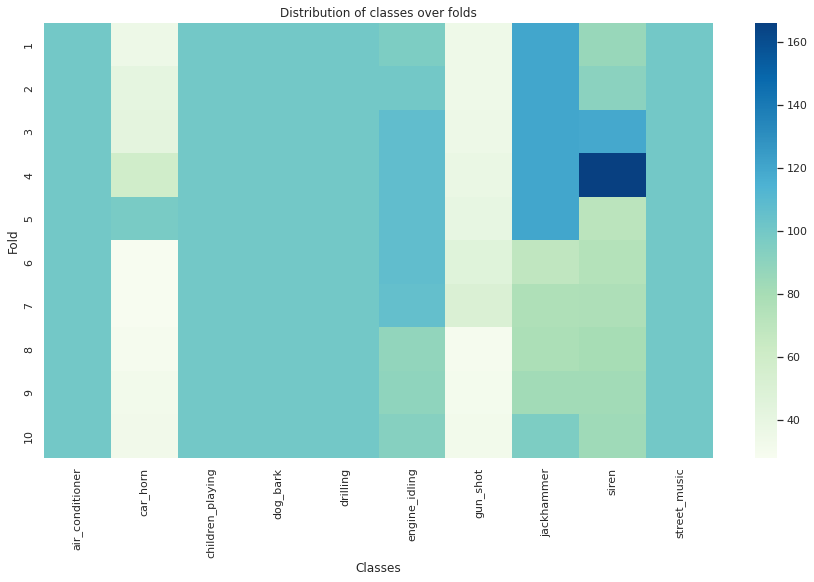

In [6]:
plots.classes_per_fold(metadata)

Additionally, the length of the sound excerpts can be determined using the start and end times specified in the meta data file.

The distribution of the binned length of the sound excerpts is shown below. Note that intervals were used since the number of unique lengths was too large to display separately. The vast majority of observations have a duration between 3 and 4 seconds. However, it should be noted that ~98\% of all files in the interval $(3, 4]$ have an exact duration of 4 seconds. 

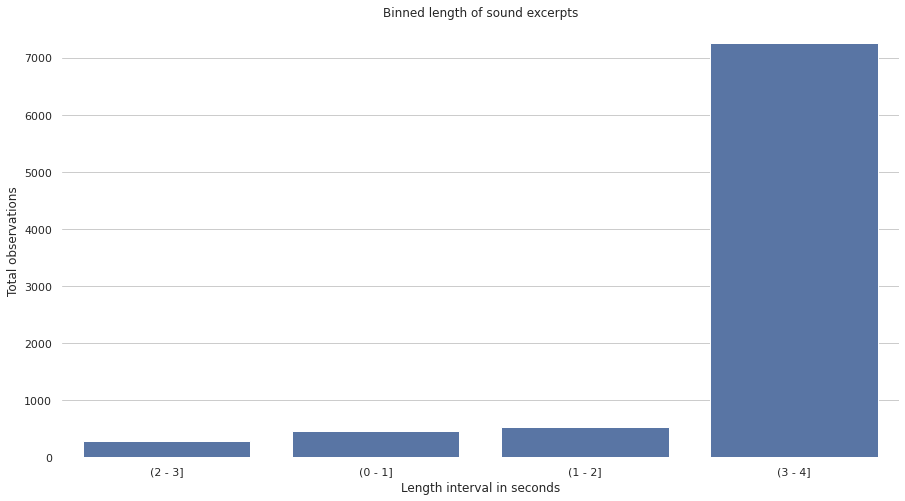

In [7]:
plots.duration(metadata)

The figures below show an example waveplot for each class.

In [4]:
base_example_audio_path = "/home/msc1/Desktop/CW/7146/examples/"
example_audio_paths = ["7061-6-0-0.wav",
                       "14113-4-0-0.wav",
                       "15564-2-0-0.wav",
                       "17592-5-1-0.wav",
                       "21684-9-0-5.wav",
                       "24074-1-0-0.wav",
                       "57320-0-0-39.wav",
                       "106905-8-0-2.wav",
                       "180937-7-2-4.wav",
                       "7383-3-0-0.wav"]

example_audio_paths = [base_example_audio_path + audio_path for audio_path in example_audio_paths]

example_audio_classes = ["gun shot",
                         "drilling",
                         "children playing",
                         "engine idling",
                         "street music",
                         "car horn",
                         "air conditioner",
                         "siren",
                         "jackhammer",
                         "dog bark"]

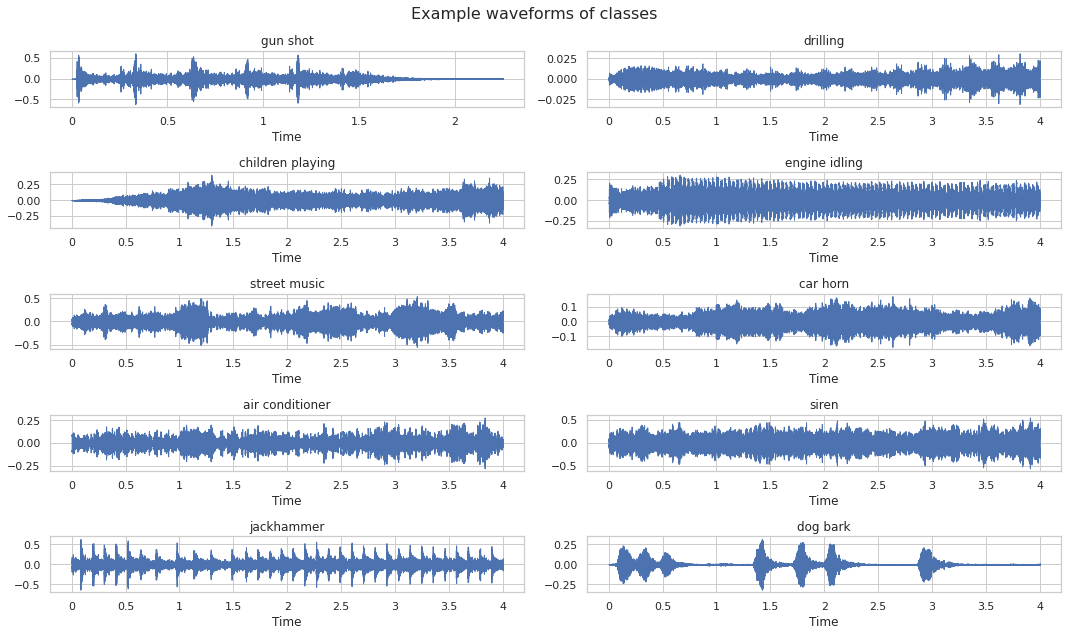

In [5]:
plots.waveplots(example_audio_paths, example_audio_classes)

# Pre-processing

Several pre-processing steps are required to transform the raw audio files (.wav) to a machine learning-compatible format. A multi-input model will be utilised. As input, both the raw waveform and the so-called Mel spectrogram will be employed as the Mel spectrograms and the raw waveform can capture distinct patterns in a given sound excerpt. 

This section defines the different pre-processing steps as functions. These functions are then used to build the pre-processing pipeline later on.

## Loading, resampling and rechannel

All files have to have an identical sampling rate. Otherwise, the resulting sequence length would vary among the samples. The sampling rate is the number of samples that are taken within each second of the audio signal - this converts the continuous sound signal to a discrete signal that can be further processed. Therefore, the sampling rate determines (together with the length of the sound excerpts) the length of the resulting vector when loading the audio file. Due to this, the sampling rate is directly related to the computational complexity (time and memory) of further pre-processing steps and especially the model tuning and training.

Furthermore, each file will be rechanneled to a mono channel to achieve consistency across the samples. The Librosa `load` function encapsulates the loading, resampling and rechanneling functionality.

In [4]:
def load_wav(path, sr, rechannel):
    """
    Load, resample, and rechannel a wav file.
    """
    return librosa.load(path, sr=sr, mono=rechannel)[0]

## Padding

Due to variances in durations, not all sequences are of equal length, as seen in the EDA. While global pooling could be used to process sequences of varying lengths with CNNs, this approach uses a fixed sequence length as the vast majority of the used audio files have a duration of exactly 4 seconds and hence a constant sequence length.  Sequences/files that are less than 4 seconds in duration will be padded with zeros to fit the necessary sequence length. 

In [ ]:
def pad(arr, size):
    """
    Pad the arr to the given size.
    """
    return librosa.util.fix_length(arr, size=size)

## Data augmentation

Based on the previous transformations the resulting sequential data can be augmented. Although data augmentation is not strictly required for resampling purposes due to the only minor class imbalance, it can improve model performance and reduce the risk of overfitting due to the increased amount of data. As the employed model architecture is quite flexible, augmented data can help the model to generalise well. Two augmentation techniques are used:

### Time shifting

The signal will be shifted and rolled over such that the part of the sequence that exceeds the fixed sequence length will be re-introduced at the start of the sequence.

In [6]:
def time_shift(arr, n):
    """
    Shift the arr by n steps
    """
    return np.roll(arr, n)

### Pitch shifting

Raise or lower the pitch of the sound exhibit.

In [7]:
def pitch_shift(arr, sr, shift):
    """
    Shift the pitch of a waveform by n_steps steps.
    """
    return librosa.effects.pitch_shift(arr, sr=sr, n_steps=shift)

## Generating the Mel spectrogram

As described above, we will use a multi-input network that utilises both the raw waveform and the so-called Mel spectrogram. With the pre-processing steps outlined above, we have now obtained the raw waveform. We can then generate the Mel spectrogram as follows:

In [21]:
def mel_spectrogram(arr, sr, n_fft=2048, hop_length=512):
    """
    Compute a mel spectrogram from the given waveform.
    """
    mel_spec = librosa.feature.melspectrogram(y=arr, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return librosa.power_to_db(mel_spec)

## Defining the pre-processing pipeline

Several pre-processing tasks outlined above require a significant amount of time to compute. Due to extensive experimentation with regard to the network architecture and hyperparameters, it was not feasible to compute the pre-processing steps on-demand every time a new experiment was run. Instead, all pre-processing tasks for all files were precomputed and stored in HDF5 format. The HDF5 format is well suited to store large multidimensional arrays and allows for extremely fast access times. Furthermore, it removes the necessity to work with thousands of individual files and instead has them combined in only a few files.

First, we add the relative paths of all .wav files to the metadata file such that they can easily be accessed in the next step.

In [2]:
def prepare_metadata(metadata_path, folds_dir):
    """
    Prepares the metadata to include the relative path to the wav file. Drops irrelevant columns.
    """

    def add_rel_path(row):
        """
        Adds the relative path to the wav file to the metadata.
        """
        return folds_dir + f"/fold{str(row['fold'])}" + f"/{str(row['slice_file_name'])}"

    df = pd.read_csv(metadata_path)
    df["rel_path"] = df.apply(add_rel_path, axis=1)
    df = df[["rel_path", "fold", "classID"]]
    return df

Now we define the pre-processing pipeline. Note that a separate .hdf5 file is generated for each fold. Additionally, the original data is not concatenated with the augmented data within the HDF file. During training, we want to include just the augmented data for the folds that are being utilised as the train set. The test set must not contain any augmented data. 

We will use cross-validation during training. Cross-validation uses a different set of folds as the training set on each iteration. Therefore, on each iteration, the folds of which we will load the augmented data changes. 

Separating the original data from the augmented data within the HDF file helps access the correct data for each cross-validation iteration.  

In [9]:
def precompute_preprocessing(metadata: pd.DataFrame, target_dir: Path, sampling_rate: int, arr_size: int):
    """
    Precomputes the preprocessing tasks and stores them in .hdf5 format.
    :param metadata: The (loaded) metadata file
    :param target_dir: The target directory to store the processed data
    :param sampling_rate: The target sampling rate
    :param arr_size: The target array size. This is relevant when padding sequences that are too short and is calculated
     as follows: sampling_rate * seconds
    """

    # Augmentation params
    N_TIME_SHIFTS = 2
    TIME_SHIFT_INTERVAL_START = 0.05
    TIME_SHIFT_INTERVAL_END = 1.0

    PITCH_SHIFTS = [-3.5, -2.5, -2.0, -1.0, 1.0, 2.0, 2.5, 3.5]

    # Process fold wise
    for name, grp in metadata.groupby("fold"):

        # Get path and label of each file
        wav_paths = grp["rel_path"].tolist()
        labels = grp["classID"].tolist()

        # Lists that will keep the computed data
        plain = []
        plain_mel = []
        plain_labels = []

        augmented = []
        augmented_mel = []
        augmented_labels = []

        # Process each file and each label
        for wav_path, label in tqdm(zip(wav_paths, labels), total=len(wav_paths)):

            # Load and pad
            arr_plain = load_wav(wav_path, sr=sampling_rate, rechannel=True)
            arr_plain = pad(arr_plain, arr_size)

            # Append the "plain" (e.g. not augmented) data

            # Reshape from (arr_size,) to (arr_size, 1) as the 1D CNN expects the timesteps in the first dimension and
            # the features in the second dimension
            plain.append(arr_plain.reshape(-1, 1))

            # Append the "plain" (e.g. not augmented) mel-spectrogram
            plain_mel.append(mel_spectrogram(arr_plain, sr=sampling_rate))

            # Lastly, append the label
            plain_labels.append(label)

            # Augmentation

            # Time shift
            for _ in range(N_TIME_SHIFTS):
                # Randomly select a time shift (within the given interval)
                shift = int(arr_plain.shape[0] * random.uniform(
                    TIME_SHIFT_INTERVAL_START,
                    TIME_SHIFT_INTERVAL_END))

                # Apply shift
                shifted = time_shift(arr_plain, shift)

                # Same as with the "plain" data
                augmented.append(shifted.reshape(-1, 1))
                augmented_mel.append(mel_spectrogram(shifted, sr=sampling_rate))
                augmented_labels.append(label)

            # Pitch shift
            for pitch_shift in PITCH_SHIFTS:
                # Apply shift
                shifted = pitch_shift(arr_plain, sampling_rate, pitch_shift)

                # Same as with the "plain" data
                augmented.append(shifted.reshape(-1, 1))
                augmented_mel.append(mel_spectrogram(shifted, sr=sampling_rate))
                augmented_labels.append(label)

        # Convert the gathered data to numpy arrays and stack them.
        # This adds an additional dimension along a new axis (basically stacks the individual arrays on
        # top of each other)
        plain = np.stack(np.array(plain), axis=0)
        plain_mel = np.stack(np.array(plain_mel), axis=0)
        plain_labels = np.stack(np.array(plain_labels), axis=0)
        augmented = np.stack(np.array(augmented), axis=0)
        augmented_mel = np.stack(np.array(augmented_mel), axis=0)
        augmented_labels = np.stack(np.array(augmented_labels), axis=0)

        # Create a hdf5 file and save the data
        store = h5py.File(target_dir / f"{name}.h5", "w")
        store.create_dataset("plain_x", data=plain)
        store.create_dataset("plain_mel_x", data=plain_mel)
        store.create_dataset("plain_y", data=plain_labels)
        store.create_dataset("augmented_x", data=augmented)
        store.create_dataset("augmented_mel_x", data=augmented_mel)
        store.create_dataset("augmented_y", data=augmented_labels)
        store.close()


## Running the pre-processing pipeline

In [3]:
metadata_df = prepare_metadata("/home/msc1/Desktop/CW/7146_data/UrbanSound8K.csv", "/home/msc1/Desktop/CW/7146_data")

The metadata file now only holds relevant data (including the path to each .wav file).

In [4]:
metadata_df.head()

,rel_path,fold,classID
0,/home/msc1/Desktop/CW/7146_data/fold5/100032-3...,5,3
1,/home/msc1/Desktop/CW/7146_data/fold5/100263-2...,5,2
2,/home/msc1/Desktop/CW/7146_data/fold5/100263-2...,5,2
3,/home/msc1/Desktop/CW/7146_data/fold5/100263-2...,5,2
4,/home/msc1/Desktop/CW/7146_data/fold5/100263-2...,5,2


In [5]:
pre_processing_params = dict(
    metadata= metadata_df,
    target_dir= Path("/home/msc1/Desktop/CW/7146_data/8000/"),
    sampling_rate= 8000,
    arr_size= 32000 # 8000 (sampling rate ) * 4 (seconds)
)

In [10]:
precompute_preprocessing(**pre_processing_params)

Executing the pipeline results in 10 .hdf5 files, each around 1.5 GB in size:

![](jupyter_files/imgs/hdf_dir.png)

with each file holding six datasets:
- [plain_x] the raw signal for each .wav file (loaded and padded)
- [plain_mel_x] the Mel spectrogram for each .wav file
- [plain_y] the label for each .wav file
- [augmented_x] the augmented versions of each file (10 per file)
- [augmented_mel_x] the Mel spectrogram for each augmented file 
- [augmented_y] the label for each augmented file

We can now look at some of the files.

In [8]:
%%timeit -r 1 -n 1

store = h5py.File(pre_processing_params["target_dir"] / f"1.h5", "r")
x = store["plain_x"][:]
x_mel = store["plain_mel_x"][:]
y = store["plain_y"][:]

x_aug = store["augmented_x"][:]
x_mel_aug = store["augmented_mel_x"][:]
y_aug = store["augmented_y"][:]

store.close()

274 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Loading all the files of fold 1 takes only a few hundred ms. This includes the augmented files, which are 10x the amount of the original files.

As we can see, for fold 1, we have 873 files (arrays), each with 32000 "rows" and 1 "column".

In [9]:
x.shape

(873, 32000, 1)

same for the augmented data (despite it being 10 times the amount of arrays)

In [49]:
x_aug.shape

(8730, 32000, 1)

and the Mel spectrograms are stored in the same way:

In [50]:
print(x_mel.shape)
print(x_mel_aug.shape)

(873, 128, 63)
(8730, 128, 63)


and finally the labels:

In [51]:
print(y.shape)
print(y_aug.shape)

(873,)
(8730,)


Once precomputed, the data can now be accessed in seconds (at least for a single fold).

# Network

As mentioned previously, a multi-input model is used. The model will use the raw waveform and the Mel spectrogram from each of the .wav files as input, requiring two different feature extractors.

We will first define the 1D feature extractor (raw signal) and then the 2D feature extractor (Mel spectrogram). 

Note that we will have to use the functional API of TensorFlow as the Sequential API is not flexible enough to allow for multi-input models.

## 1D

The architecture of the 1D feature extractor is defined below:

In [10]:
def network_1d(input_shape):
    inp = Input(shape=input_shape)

    x = Conv1D(filters=16, kernel_size=64, strides=2, activation="relu")(inp)
    x = MaxPool1D(pool_size=8, strides=8)(x)
    x = Conv1D(filters=32, kernel_size=32, strides=2, activation="relu")(x)
    x = MaxPool1D(pool_size=8, strides=8)(x)
    x = Conv1D(filters=64, kernel_size=16, strides=2, activation="relu")(x)
    x = Conv1D(filters=128, kernel_size=8, strides=2, activation="relu")(x)

    x = Flatten()(x)
    return Model(inputs=inp, outputs=x)

The increasing number of filters and the decreasing kernel size helps with building hierarchical features from the input. The goal is to enable the model to learn more low-level features in the early layers and then granularly learn more high-level features as the architecture becomes more complex. Furthermore, max pooling is used to compress nearby information (values in the feature-map of each filter). Finally, the output is flattened. 

## 2D

The architecture of the 2D feature extractor is defined below:

In [11]:
def network_2d(input_shape):
    inp = Input(shape=input_shape)

    x = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")(inp)
    x = BatchNormalization()(x)
    x = Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = AvgPool2D(pool_size=2)(x)

    x = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")(x)
    x = Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = AvgPool2D(pool_size=2)(x)

    x = Flatten()(x)
    return Model(inputs=inp, outputs=x)

This feature extractor's architecture is similar to that of the first - the number of filters increases, and the kernel size decreases as the layer depth increases. However, 2D (instead of 1D) convolutional layers are employed since the Mel spectrogram is used as input. Because the spectrogram is very dense, a stride of 1 is used across all layers.

Instead of normalising the input to both feature extractors, only the input to the 2D feature extractor is normalised (batch-wise). Experiments indicated that standardising the data prior to passing it to the feature extractors had no effect on performance (which is also to be expected as all inputs share the same "unit", regardless of normalisation). 

Note the addition of several Dropout layers as a regularisation technique. 

## Shared

Both feature extractors' outputs are concatenated before being passed to the final classification layers depicted below. The last fully-connected layer uses the softmax activation function as it should yield a probability vector over the ten classes present in the dataset (hence ten units). 

As was the case with the 2D feature extractor, several Dropout layers were added as a regularisation technique.

In [12]:
def network_shared(conc):
    x = Dropout(0.4)(conc)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(10, activation="softmax")(x) # Because we have 10 classes
    return x

## Full network

With the different parts of the network defined we can now form the final network.

In [13]:
def network(m1, m2):
    conc = concatenate([m1.output, m2.output])
    return tf.keras.Model(inputs=[m1.input, m2.input], outputs=network_shared(conc))

We may now specify the network's input shapes. Note that for the 2D network, we had to add a third dimension representing the channel, which 2D CNNs require.

In [14]:
input_shape_d1 = (32000, 1)
input_shape_d2 = (128, 63, 1)

In [16]:
model = network(network_1d(input_shape_d1),
                network_2d(input_shape_d2))

Model summary (has to be build or compiled beforehand): 

In [17]:
model.build([x, x_mel]) # Note that the multi-input is passed as a list
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 63, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 61, 64)  640         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 126, 61, 64)  256        ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                            

# Training

As previously mentioned, special attention must be paid to how the training is conducted. The [authors](https://dl.acm.org/doi/10.1145/2647868.2655045) emphasise that the performance on the dataset should not be evaluated through a standard train-/test split as many slices originate from the same recording. Consequently, in a regular train-/ test split, training data leaks into the test set, making the results inaccurate.

Instead, the provided folds must be used. This is because [not all the splits are as "easy". That is, models tend to obtain much higher scores when trained on folds 1-9 and tested on fold 10](https://urbansounddataset.weebly.com/urbansound8k.html).

Therefore, results obtained from a regular train-/test split are not comparable to the average accuracy obtained from training the model on a 10-fold cross-validation.

Each cross-validation iteration will use 9 folds as the training set and 1 fold as the test set. We, therefore, define a CVIteration helper class and a function to generate the possible combinations.

For each combination, a CVIteration instance will be created. Each CVIteration instance holds the folds for its train- and test sets, respectively. These folds can easily be loaded by calling `load_train()` and `load_test()`. Note that when calling `load_train()`, the augmented data is loaded, while when calling `load_test()`, no augmented data is loaded.

In [6]:
class CVIteration:

    def __init__(self, train_folds, test_fold):
        self.train_folds = train_folds
        self.test_fold = test_fold

        self.folds_dir = None

    def get_from_store(self, folds, keys):
        """
        Receive a set of keys from a .hdf5 file
        """

        values = {key: [] for key in keys}

        for fold in folds:

            store = h5py.File(self.folds_dir / f"{fold}.h5", "r")

            for key in keys:
                values[key].append(store[key][:])

            store.close()

        for val in values:
            values[val] = np.concatenate(values[val], axis=0)

        return values

    def load_train_set(self):

        keys = ["plain_x", "plain_y", "augmented_x", "augmented_y", "plain_mel_x", "augmented_mel_x"]

        res = self.get_from_store(self.train_folds, keys)
        concat_x = np.concatenate([res["plain_x"], res["augmented_x"]], axis=0)
        concat_y = np.concatenate([res["plain_y"], res["augmented_y"]], axis=0)
        concat_mel_x = np.concatenate([res["plain_mel_x"], res["augmented_mel_x"]], axis=0)
        return concat_x, concat_mel_x, concat_y

    def load_test_set(self):
        res = self.get_from_store([self.test_fold], ["plain_x", "plain_mel_x", "plain_y"])
        return res["plain_x"], res["plain_mel_x"], res["plain_y"]

    def __str__(self):
        return f"Fold(train_folds={self.train_folds}, test_fold={self.test_fold})"

    def __repr__(self):
        return str(self)

To generate all possible combinations and their respective CVIteration instances:

In [7]:
def make_10kfold(folds: list, folds_dir):
    folds = np.array(folds)

    train = []
    test = []

    # (There is probably a smarter way to do this)
    for _ in range(len(folds)):
        test.append(folds[0])
        train.append(folds[1:])
        folds = np.roll(folds, 1)

    cv = [CVIteration(train_folds=train_folds, test_fold=test_fold) for train_folds, test_fold in zip(train, test)]

    for ite in cv:
        ite.folds_dir = Path(folds_dir)

    return cv

In [20]:
cv = make_10kfold([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], # The integers reflect the filenames of the .hdf5 files (and, therefore, the folds)
                  folds_dir = pre_processing_params["target_dir"])

We can now look at all combinations within the 10k fold

In [21]:
for comb in cv:
    print(comb)

Fold(train_folds=[ 2  3  4  5  6  7  8  9 10], test_fold=1)
Fold(train_folds=[1 2 3 4 5 6 7 8 9], test_fold=10)
Fold(train_folds=[10  1  2  3  4  5  6  7  8], test_fold=9)
Fold(train_folds=[ 9 10  1  2  3  4  5  6  7], test_fold=8)
Fold(train_folds=[ 8  9 10  1  2  3  4  5  6], test_fold=7)
Fold(train_folds=[ 7  8  9 10  1  2  3  4  5], test_fold=6)
Fold(train_folds=[ 6  7  8  9 10  1  2  3  4], test_fold=5)
Fold(train_folds=[ 5  6  7  8  9 10  1  2  3], test_fold=4)
Fold(train_folds=[ 4  5  6  7  8  9 10  1  2], test_fold=3)
Fold(train_folds=[ 3  4  5  6  7  8  9 10  1], test_fold=2)


As we can see, all combinations are registered. We can now define the train loop to obtain the average accuracy across the 10k fold.

Besides an early stopping callback, we also implement a custom callback to store the best model in memory to restore it after training. Using the regular ModelCheckpoint callback from TensorFlow would add additional computational overhead to the either way very memory intensive training loop. 

Furthermore, saving each model to the disk does not make sense in a cross-validation setting as the individual models will not be reused later on either way. Instead, if an architecture yields acceptable accuracy over all folds, a model is trained on the whole dataset and then used in production.

In each cross-validation iteration, a new model is trained. Based on this model inference is then performed on the current test set. The predictions will be saved to calculate additional metrics later on. 

In [7]:
class SaveBestModel(tf.keras.callbacks.Callback):
    
    def __init__(self, monitor='val_accuracy'):
        """
        Stores the best model based on a given accuracy in memory.
        """
        
        self.monitor = monitor
        self.best = float('-inf')
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.monitor]

        if metric_value > self.best:
            self.best = metric_value
            self.best_weights = self.model.get_weights()

In [23]:
def train_loop(folds_dir):
    # Make CV
    cv = make_10kfold([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], folds_dir)

    # List to hold the individual accuracies
    accuracies = []
    predictions = []

    for i, ite in enumerate(cv):
        # Load the train and test set of the current iteration
        train_x, train_x_mel, train_y = ite.load_train_set()
        test_x, test_x_mel, test_y = ite.load_test_set()

        # Convert y to one-hot encoding
        train_y_cat = to_categorical(train_y, num_classes=10)
        test_y_cat = to_categorical(test_y, num_classes=10)

        # Create a new model for each iteration
        model = network(network_1d(input_shape_d1),
                        network_2d(input_shape_d2))

        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Callbacks
        # Early Stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
        # Save best model
        save_best = SaveBestModel(monitor='val_accuracy')

        # Using early stopping with only 10 episodes doesn't make the most of sense. However, it's still implemented as it
        # could save some episodes of training in some instances. 
        model.fit(x=[train_x, train_x_mel],
                     y=train_y_cat,
                     epochs=10,
                     batch_size=64,
                     validation_data=([test_x, test_x_mel], test_y_cat),
                     callbacks=[save_best, early_stopping])

        # Restore best weights
        model.set_weights(save_best.best_weights)
        
        # Predict and calculate accuracy, append to accs list
        y_pred = model.predict(x=[test_x, test_x_mel])
        y_pred = np.argmax(y_pred, axis=1)

        # Append the predictions such that we can calculate additional metrics later on
        predictions.append({i:y_pred})

        # Calculate accuracy
        acc = accuracy_score(test_y, y_pred)
        accuracies.append(acc)
        print(f"CV: {i}. Accuracy: {round(acc, 2)}")

        # Since memory is a huge issue, we explicitly delete the model and the data to make sure it's not taking up
        # memory. The garbage collector is explicitly called afterwards.
        del model
        del y_pred
        del train_x
        del train_x_mel
        del train_y
        del test_x
        del test_x_mel
        del test_y

        gc.collect()

    return np.mean(accuracies), predictions

During training, a major challenge was the enormous memory consumption due to the large amount of data that had to be loaded into memory. While the original data itself is not problematic, the 10 augmentations per file increased the original dataset dramatically — especially when considering that not only one input got augmented but two. This effectively increased the size of the dataset by a factor of 20. 

The swap had to be increased to 48 GB to cope with this issue. While setting it to 48 GB was not absolutely necessary, it was a safety measure to prevent the training process from crashing. During training, the "normal" memory + swap utilisation was roughly 36 GB: 

![](jupyter_files/imgs/memory.png)

The batch size was selected such that about 95% of VRAM was allocated during training. 10 episodes (unless early stopping triggers) were selected as the model showed no improvements after 10 episodes during the experimentation phase. 

We can now start the training:

In [24]:
mean_acc, predictions = train_loop(pre_processing_params["target_dir"])

2022-04-17 22:43:26.681378: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11065472000 exceeds 10% of free system memory.
2022-04-17 22:44:29.939948: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2788498944 exceeds 10% of free system memory.
2022-04-17 22:44:42.715504: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11065472000 exceeds 10% of free system memory.
2022-04-17 22:44:47.316893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2788498944 exceeds 10% of free system memory.


Epoch 1/10


2022-04-17 22:44:52.347940: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-17 22:44:55.136037: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1351/1351 [==============================] - 45s 29ms/step - loss: 0.7810 - accuracy: 0.7388 - val_loss: 2.0076 - val_accuracy: 0.6827
Epoch 2/10
1351/1351 [==============================] - 37s 28ms/step - loss: 0.3392 - accuracy: 0.8879 - val_loss: 1.7246 - val_accuracy: 0.6644
Epoch 3/10
1351/1351 [==============================] - 38s 28ms/step - loss: 0.2294 - accuracy: 0.9236 - val_loss: 3.0923 - val_accuracy: 0.6701
Epoch 4/10
1351/1351 [==============================] - 38s 28ms/step - loss: 0.1736 - accuracy: 0.9424 - val_loss: 2.6655 - val_accuracy: 0.7010
Epoch 5/10
1351/1351 [==============================] - 38s 28ms/step - loss: 0.1464 - accuracy: 0.9522 - val_loss: 3.4796 - val_accuracy: 0.6770
Epoch 6/10
1351/1351 [==============================] - 38s 28ms/step - loss: 0.1217 - accuracy: 0.9605 - val_loss: 3.6830 - val_accuracy: 0.6816
Epoch 7/10
1351/1351 [==============================] - 38s 28ms/step - loss: 0.1167 - accuracy: 0.9632 - val_loss: 4.2189 - val_accura

2022-04-17 22:52:34.762751: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11116160000 exceeds 10% of free system memory.


Epoch 1/10
1357/1357 [==============================] - 40s 29ms/step - loss: 0.8767 - accuracy: 0.7006 - val_loss: 1.0687 - val_accuracy: 0.7312
Epoch 2/10
1357/1357 [==============================] - 38s 28ms/step - loss: 0.3614 - accuracy: 0.8798 - val_loss: 1.0251 - val_accuracy: 0.7348
Epoch 3/10
1357/1357 [==============================] - 38s 28ms/step - loss: 0.2391 - accuracy: 0.9198 - val_loss: 1.2647 - val_accuracy: 0.7395
Epoch 4/10
1357/1357 [==============================] - 38s 28ms/step - loss: 0.1853 - accuracy: 0.9398 - val_loss: 1.2858 - val_accuracy: 0.7539
Epoch 5/10
1357/1357 [==============================] - 38s 28ms/step - loss: 0.1554 - accuracy: 0.9489 - val_loss: 1.4341 - val_accuracy: 0.7395
Epoch 6/10
1357/1357 [==============================] - 38s 28ms/step - loss: 0.1324 - accuracy: 0.9570 - val_loss: 1.2380 - val_accuracy: 0.7885
Epoch 7/10
1357/1357 [==============================] - 38s 28ms/step - loss: 0.1147 - accuracy: 0.9629 - val_loss: 1.5097 -

Training took about 90 mins. 

During the whole training process, the training loss decreased while the training accuracy increased (which is expected). However, we can observe that in some CV iterations, both the validation (e.g. test) loss and the validation accuracy increased.

This is a rather odd phenomenon and is most likely caused by overfitting (hence Dropout layers were heavily used). Loss measures the raw difference between a prediction and the true label where the prediction is a probability distribution and the label a one-hot encoded vector. The accuracy, however, is thresholded, meaning as long as a particular class has the highest probability, it will compare this class to the actual label. While the loss increases if the probability of the correct class decreases, the accuracy may still report the correct class as long as it is the class with the highest probability.

However, only a few iterations show this phenomenon. As shown in the EDA, the different folds can differ significantly in class distribution, leading to train- and test combinations where the patterns found in the trainset are difficult to match the pattern in the test set accurately - leading to bad generalisation and overfitting.

Next, we will calculate the average accuracy over the 10k fold and see the individual classification reports.

In [4]:
print(f"Average accuracy across 10k fold: {round(mean_acc * 100, 2)} %")

Average accuracy across 10k fold: 76.56 %


In [60]:
classes = ["air_cond.", "car_horn",
           "child._play.", "dog_bark",
           "drilling", "engine_idling",
           "gun_shot", "jackhammer",
           "siren", "street_music"]

In [61]:
cv = make_10kfold([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], pre_processing_params["target_dir"])

classification_reports = []

for i, ite in enumerate(cv):
    # As we are interested in the metrics we only keep test_y
    _, _, test_y = ite.load_test_set()
    y_pred = predictions[i][i]

    print("---")
    print(f"CV iteration: {i + 1}")
    print(classification_report(test_y, y_pred, target_names=classes))
    classf_report_dict = classification_report(test_y, y_pred, target_names=classes, output_dict=True)
    classification_reports.append(pd.DataFrame(classf_report_dict).T)

---
CV iteration: 1
               precision    recall  f1-score   support

    air_cond.       0.62      0.45      0.52       100
     car_horn       0.97      0.92      0.94        36
 child._play.       0.81      0.77      0.79       100
     dog_bark       0.64      0.91      0.75       100
     drilling       0.49      0.48      0.48       100
engine_idling       0.66      0.67      0.66        96
     gun_shot       0.87      0.94      0.90        35
   jackhammer       0.54      0.46      0.50       120
        siren       0.83      0.95      0.89        86
 street_music       0.88      0.84      0.86       100

     accuracy                           0.70       873
    macro avg       0.73      0.74      0.73       873
 weighted avg       0.70      0.70      0.69       873

---
CV iteration: 2
               precision    recall  f1-score   support

    air_cond.       0.97      0.66      0.79       100
     car_horn       0.84      0.94      0.89        33
 child._play.       0

The average accuracy is ~77%. However, looking at the individual iterations, we can see that, as stated by the authors, the performance between the different fold combinations differs significantly. 

The highest accuracies were scored by iteration 3 (test fold: 9), 7 (test fold: 5) and 8 (test fold: 4), with each around 81% accuracy. 

The lowest accuracy was scored by iteration 9 (test fold: 3) with 67% accuracy. 

The confusion matrices confirm the classification reports:

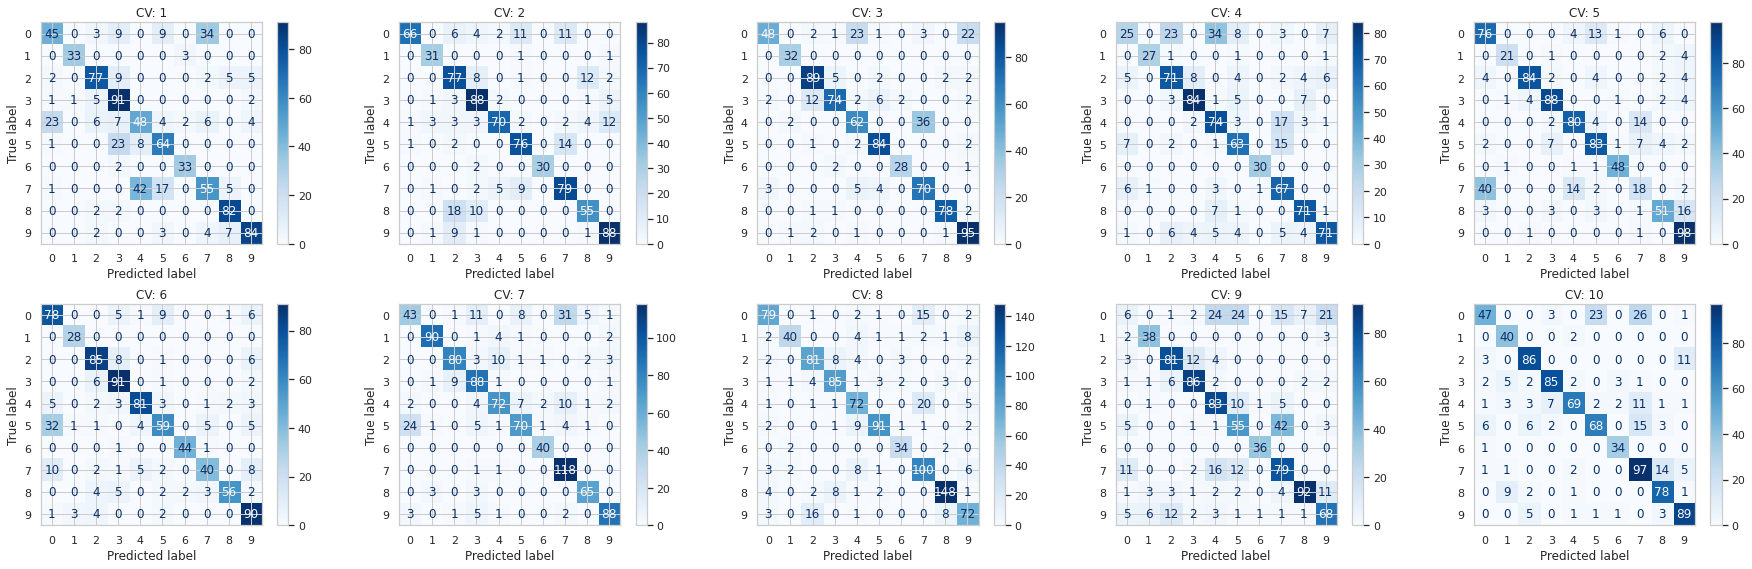

In [23]:
cv = make_10kfold([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], pre_processing_params["target_dir"])

fig, axs = plt.subplots(2, 5, figsize=(25, 8))

ax_idx = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
          (1, 0), (1, 1), (1, 2), (1, 3), (1, 4)]

for i, ite in enumerate(cv):
    # As we are interested in the metrics we only keep test_y
    _, _, test_y = ite.load_test_set()
    y_pred = predictions[i][i]

    axs[ax_idx[i]].set_title(f"CV: {i + 1}")

    cm = confusion_matrix(test_y, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=axs[ax_idx[i]], cmap='Blues')

fig.tight_layout()
plt.grid(False)

Furthermore, we can see that not all classes performed equally good/bad by retrieving the average scores across the 10k fold for precision, recall and f1 score:

In [77]:
report_concat = pd.concat(classification_reports)
report_concat["class"] = report_concat.index

avgs = []

for name, grp in report_concat.groupby("class"):
    if name in classes:
        avgs.append({"class": name, "precision": grp["precision"].mean(),
                     "recall": grp["recall"].mean(), "f1-score": grp["f1-score"].mean()})

df = pd.DataFrame(avgs)
df.sort_values(by="f1-score", ascending=False)

,class,precision,recall,f1-score
6,gun_shot,0.920292,0.954745,0.936397
1,car_horn,0.877646,0.893850,0.879965
8,siren,0.853457,0.831126,0.839197
3,dog_bark,0.802357,0.860000,0.826272
9,street_music,0.785625,0.843000,0.810103
2,child._play.,0.798966,0.811000,0.803672
5,engine_idling,0.747106,0.717671,0.729630
4,drilling,0.733550,0.711000,0.716964
7,jackhammer,0.641329,0.710229,0.663090
0,air_cond.,0.664653,0.513000,0.562187


Due to their distinct sound pattern, gunshots are very confidently recognised across all folds with an average precision of 92% and an average recall of 95%. Other confidently recognised classes (average f1-score > 80%) are the car horn, siren, dog bark, street music, and children playing. These classes have very distinct sound patterns, making them easier to distinguish. 

However, the classes engine idling, drilling and jackhammer have a substantially lower average f1 score than the other classes. This is most likely due to them sounding somewhat similar, making it harder to differentiate between them. 

The air conditioner is recognized very poorly compared to all other classes. Most of the air conditioner recordings are taken very close up, making it very hard to distinguish them from the sound of drilling or a jackhammer.

# Discussion

## On model performance

To my best knowledge, the best performing models achieved a [97.2% mean accuracy](https://www.researchgate.net/publication/332379432_Environment_Sound_Classification_Using_a_Two-Stream_CNN_Based_on_Decision-Level_Fusion/fulltext/5cb09e804585156cd791f8b8/Environment-Sound-Classification-Using-a-Two-Stream-CNN-Based-on-Decision-Level-Fusion.pdf?origin=publication_detail) with 2D CNNs and an [89% mean accuracy](https://arxiv.org/pdf/1904.08990v1.pdf) with 1D CNNs on this dataset. (I'm not considering paper or other submissions that reported their result through a regular train-/ test split without using the predefined 10k fold for previously mentioned reasons.)

The proposed architecture is significantly less performant. However, both papers mentioned above used specialized methods to extract additional features before passing them to the network. Furthermore, the individual networks were deeper (e.g. more flexible) than the one presented here. 
However, since the proposed architecture does not rely on a single input but on two distinct inputs, the complexity of each of the two feature extractors must be smaller than the one in each of the papers to avoid further overfitting. 

Finally, the goal of this project was to provide a baseline to determine whether a multi-input network is suitable for classifying environmental audio. We demonstrated that, while the performance itself is not state of the art, multi-input networks can certainly be used for audio classification. 

Outside of this project's scope but probably of interest for further research could be the implementation of the data pre-processing steps the paper mentioned above carried out for each of the two inputs. These new inputs could then be tested with a multi-input network like the one proposed here. 

For instance, [Abdoli et al. (89% accuracy)](https://arxiv.org/pdf/1904.08990v1.pdf) does not use the raw signal but overlapping windows over the signal as input for a 1D CNN. Similarly, [Su et al. (97.2% accuracy)](https://www.researchgate.net/publication/332379432_Environment_Sound_Classification_Using_a_Two-Stream_CNN_Based_on_Decision-Level_Fusion/fulltext/5cb09e804585156cd791f8b8/Environment-Sound-Classification-Using-a-Two-Stream-CNN-Based-on-Decision-Level-Fusion.pdf?origin=publication_detail) not only uses the Mel spectrogram but various other features like spectral contrast and tonal centroid as input for a 2D CNN. 

Additionally, increasing the sample rate may improve performance.
This could not be tested in this project due to the hardware limitations mentioned above. 

By implementing and merging these techniques in a multi-input network the advantages of a 1D CNN and a 2D CNN for audio classification could be combined. 